# Split the patient ids into train/val/test

In this notebook, we split the ids into train/validation/test in the proportion 70/15/15 by stratified sampling on gender, age, length of stay and whether the patient received ventilation. These are then stored in the files `train_ids.csv`, `test_ids1.csv`, `test_ids2.csv` (for train, validation and test respectively). Note that in the end, it was agreed we will use cross-validation instead of having a separate validation set, therefore we actually merged the train and validation ids (as we see in the `tables_to_csv_final.ipynb` notebook) to form the 'training set'. The test set corresponds to the ids in `test_ids2.csv`.

Note that this notebook demonstrates the procedures we used to get our ids. However, the split that we arrive at will not be identical to the one we used in our experiment, this is because the split we used was performed on an earlier version of the data.

We made quite a few changes afterwards. Even though subsequently, we have 173 more subject_ids, it turns out that those do not have any vital sign information, and therefore it is reasonable to exclude those. Therefore, since splitting on

If replication of our experiment is desired, then the section of the end of this notebook will show you how. There we call our old merge data SQL file to get the dataframe, from which we can obtain the identical set of ids through stratified sampling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from sklearn.model_selection import train_test_split

## 1. Accessing MIMIC database with SQL queries

In [2]:
sqluser = 'mimicuser' 
dbname = 'mimic'

In [3]:
schema_name = 'mimiciii'
query_schema = 'SET search_path to public,' + schema_name + ';'

In [4]:
import getpass
password = getpass.getpass() 

········


In [5]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host="localhost", password=password)

In [6]:
def load_from_sql(script, con, schema_name):
        # Read the SQL query from the provided sql script
        f = open(script, 'r')
        sql_query = f.read()
        f.close()
        df = execute_query(sql_query, con, schema_name)
        return df

def execute_query(query, con, schema_name):
    cur = con.cursor()
    cur.execute('SET search_path to ' + schema_name)
    return pd.read_sql_query(query,con)

In [7]:
pd.set_option('display.max_columns', None)

### Splitting the data on non-infants by subject_id

In this section, we demonstrate how to split our data into 70% train, 15% validation and 15% test data by stratifying on age, gender, length of stay, and whether the patient was ever ventilated. 

First we select those columns that we are interested in, note that in our extraction process, all the infants have been removed.

In [8]:
query = query_schema + \
"""
select subject_id, icustay_id, age, gender, los_icu, on_vent, heart_rate,
       heart_rhythm, nbp_sys, nbp_dias, nbp_mean, abp_sys,
       abp_dias, abp_mean, temp_site, temp_celcius, verbal_response,
       o2sat, resp_rate, resp_rate_spont, resp_rate_set,
       resp_rate_total, minute_vol, mean_airway_pressure,
       peak_insp_rate, plateau_pressure, o2flow_chart, o2_device,
       vent_mode, tidal_vol_set, tidal_vol_obs,
       tidal_vol_spon, peep_set, fio2_chart, glucose_chart
from extracted_data
"""

df = pd.read_sql_query(query,con)

In [9]:
min(df.age)

14.9107

Next there are some people without any key vital signs that we remove. It is a reasonble exclusion to make as these are typically easy to measure and important for a lot of medical scores. 

In [10]:
df['vitals'] = df[['heart_rhythm', 'nbp_sys', 'nbp_dias', 'nbp_mean', 'abp_sys',
       'abp_dias', 'abp_mean', 'temp_celcius', 'o2sat', 'resp_rate']].min(axis=1)

In [11]:
keep_ids = df[~df.vitals.isnull()].subject_id.unique()

In [12]:
df2 = df[df.subject_id.isin(keep_ids)]

Next we create a dataframe with all the key columns that we want to do stratified sampling on.

In [13]:
df_key = df2[['subject_id','age', 'gender', 'los_icu','on_vent']].drop_duplicates()

In [14]:
sum(df_key.on_vent)

24878

In [15]:
len(df_key.subject_id.unique())

38417

Next we group together the information across multiple visit for each patient.

In [16]:
los = df_key.groupby('subject_id', as_index=False)['los_icu'].sum()

In [17]:
vent = df_key.groupby('subject_id', as_index=False)['on_vent'].max()

In [18]:
max_age = df_key.groupby('subject_id', as_index=False)['age'].max()

In [19]:
df_key2 = df_key[['subject_id', 'gender']].drop_duplicates()
df_key3 = pd.merge(df_key2, vent, left_on='subject_id', right_on='subject_id')
df_key4 = pd.merge(df_key3, los, left_on='subject_id', right_on='subject_id')
df_key5 = pd.merge(df_key4, max_age, left_on='subject_id', right_on='subject_id')

In [20]:
df_key5.head()

,subject_id,gender,on_vent,los_icu,age
0,55973,F,1,92.0,61.9589
1,27513,M,1,12.0,48.2940
2,10950,M,1,22.0,54.7500
3,20707,M,0,1.0,43.3439
4,29904,F,1,4.0,47.5548


Since age and length of stay are continuous variables (though we have rounded values here), we will create several bins and do stratified sampling on the binned age/LOS.

(array([3.7287e+04, 9.3900e+02, 1.3600e+02, 3.7000e+01, 9.0000e+00,
        4.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,  53.8, 107.6, 161.4, 215.2, 269. , 322.8, 376.6, 430.4,
        484.2, 538. ]),
 <BarContainer object of 10 artists>)

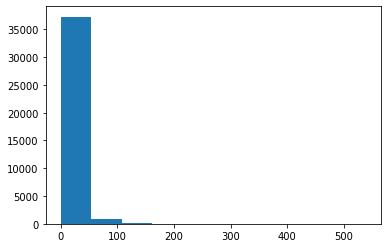

In [21]:
plt.hist(df_key5.los_icu)

In [22]:
bins = [0.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0]
los_binned = np.digitize(df_key5['los_icu'], bins)

df_key5['los_binned'] = los_binned

In [23]:
df_key5['los_binned'].value_counts()

2    8118
1    7797
3    6493
7    6447
4    3528
6    3425
5    2609
Name: los_binned, dtype: int64

(array([ 773., 1237., 1379., 2291., 3800., 5103., 5816., 5707., 6186.,
        6125.]),
 array([14.9107 , 22.41963, 29.92856, 37.43749, 44.94642, 52.45535,
        59.96428, 67.47321, 74.98214, 82.49107, 90.     ]),
 <BarContainer object of 10 artists>)

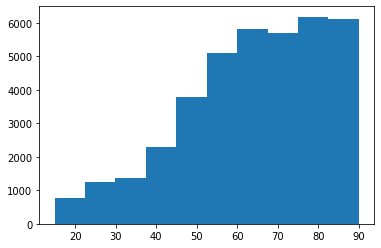

In [24]:
plt.hist(df_key5.age)

In [25]:
bins = [0.0, 50.0, 65.0, 77.0]
age_binned = np.digitize(df_key5['age'], bins)

df_key5['age_binned'] = age_binned
df_key5['age_binned'].value_counts()

4    10661
2    10411
3     9282
1     8063
Name: age_binned, dtype: int64

We are now ready to stratify the subject_ids

In [26]:
df_train, df_test, = train_test_split(df_key5, test_size=0.3, random_state=16198, \
                                      stratify = df_key5[['age_binned', 'gender', 'los_binned', 'on_vent']])

train_id = df_train.subject_id
test_id = df_test.subject_id

In [27]:
df_test1, df_test2, = train_test_split(df_test, test_size=0.5, random_state=12676, \
                                       stratify = df_test[['age_binned', 'gender', 'los_binned', 'on_vent']])

test_id1 = df_test1.subject_id
test_id2 = df_test2.subject_id

Save these ids

In [28]:
train_int = np.array(train_id).astype(int)
#test_int = np.array(test_id).astype(int)
test_int1 = np.array(test_id1).astype(int)
test_int2 = np.array(test_id2).astype(int)

np.savetxt('./split_ids/train_id.csv', train_int, fmt='%i')
#np.savetxt('./split_ids/test_id.csv', test_int, fmt='%i')
np.savetxt('./split_ids/test_id1.csv', test_int1, fmt='%i')
np.savetxt('./split_ids/test_id2.csv', test_int2, fmt='%i')

### Replicating the exact ids used

As mentioned above, the above ids will be the exact same ones that we used. The actual split that we used was based on an earlier version of the data. Subsequent extractions included a greater number of patients, in the interest of keeping the experiment 'blind', we did not subsequently change the train/test split. We note that these new ids actually have no vital sign information (aside from glucose), and hence in the demonstration above, we actually filter those out.

In this section, we will create a dataframe based on the earlier SQL code and use this dataframe in the stratified sampling to replicate the same split.

Let's begin by loading the dataframe (note this may take a while)

In [29]:
df_original = load_from_sql('./sql/merged_original.sql', con, schema_name)

We see that for the non-infant population, in our final data extraction, we have 173 new patients

In [30]:
len(set(df_original[df_original.age>14.9].subject_id.unique()).difference(df.subject_id.unique()))

0

In [31]:
len(set(df.subject_id.unique()).difference(df_original[df_original.age>14.9].subject_id.unique()))

173

We can now check that indeed that these new patients have no vital sign data

In [32]:
new_patients = list(set(df.subject_id.unique()).difference(df_original[df_original.age>14.9].subject_id.unique()))

df[df.subject_id.isin(new_patients)].vitals.unique()

array([nan])

In [33]:
df_adults2 = df_original[df_original.age>14.9]
df_original_key = df_adults2[['subject_id','age', 'gender', 'los_icu','starttime_first_vent' ]].drop_duplicates()
vented =  [not pd.isnull(df_original_key.starttime_first_vent.iloc[i]) for i in range(len(df_original_key))]
df_original_key['vented'] = vented

In [34]:
df_original_key.head()

,subject_id,age,gender,los_icu,starttime_first_vent,vented
0,55973,61.0499,F,3.0,NaT,False
128,27513,48.2940,M,6.0,2199-08-03 18:00:00,True
310,10950,54.0710,M,1.0,2159-09-03 13:00:00,True
341,20707,43.3439,M,1.0,NaT,False
373,29904,47.5548,F,2.0,2189-11-30 18:10:00,True


In [35]:
los = df_original_key.groupby('subject_id', as_index=False)['los_icu'].sum()

In [36]:
vent = df_original_key.groupby('subject_id', as_index=False)['vented'].max()

In [37]:
max_age = df_original_key.groupby('subject_id', as_index=False)['age'].max()

In [38]:
df_original_key2 = df_original_key[['subject_id', 'gender']].drop_duplicates()
df_original_key3 = pd.merge(df_original_key2, vent, left_on='subject_id', right_on='subject_id')
df_original_key4 = pd.merge(df_original_key3, los, left_on='subject_id', right_on='subject_id')
df_original_key5 = pd.merge(df_original_key4, max_age, left_on='subject_id', right_on='subject_id')

In [39]:
df_original_key5.head()

,subject_id,gender,vented,los_icu,age
0,55973,F,True,55.0,61.6879
1,27513,M,True,6.0,48.2940
2,10950,M,True,12.0,54.7500
3,20707,M,False,1.0,43.3439
4,29904,F,True,2.0,47.5548


In [40]:
bins = [0.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0]
los_binned = np.digitize(df_original_key5['los_icu'], bins)

df_original_key5['los_binned'] = los_binned
bins = [0.0, 50.0, 65.0, 77.0]
age_binned = np.digitize(df_original_key5['age'], bins)

df_original_key5['age_binned'] = age_binned


In [41]:
df_train, df_test, = train_test_split(df_original_key5, test_size=0.3, random_state=16198, \
                                      stratify = df_original_key5[['age_binned', 'gender', 'los_binned', 'vented']])

train_id = df_train.subject_id
test_id = df_test.subject_id

In [42]:
df_test1, df_test2, = train_test_split(df_test, test_size=0.5, random_state=12676,\
                                       stratify = df_test[['age_binned', 'gender', 'los_binned', 'vented']])

Next we test this split against the ids we used for our analysis

In [43]:
train = pd.read_csv('./original_ids/train_id.csv', delimiter=',', names=['subject_id'])

In [44]:
len(set(train.subject_id).difference(set(train_id)))

0

In [45]:
test1 = pd.read_csv('./original_ids/test_id1.csv', delimiter=',', names=['subject_id'])

In [46]:
len(set(test1.subject_id).difference(set(df_test1.subject_id)))

0

In [47]:
test2 = pd.read_csv('./original_ids/test_id2.csv', delimiter=',', names=['subject_id'])

In [48]:
len(set(test2.subject_id).difference(set(df_test2.subject_id)))

0

As we see, there are no differences between the split done above and our previously saved ids.

These original ids can be saved/copied over to `split_ids` folder if desired